In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/res/')
from BySanti import filter

In [5]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_sets/Entrenamieto_ECI_2020.csv')
filter.full_correction(train)

In [5]:
# empezamos por obtener un DF reducido con los campos de interes
# - Opportunity_ID  (nos permitira agrupar los renglones de la misma oportunidad)
# - ASP / ASP_(converted)_Currency nos permitira obtener un ratio de relacion de 
#   forma de expresar todas las ventas en la misma
#   moneda (USD) y de esta forma al estar poder compararlas
red_op = train[["Region", "ASP", "ASP_(converted)_Currency", "Opportunity_ID", "Stage"]]
red_op.head(5)

,Region,ASP,ASP_(converted)_Currency,Opportunity_ID,Stage
0,EMEA,0.52,USD,0,Closed Lost
1,EMEA,0.53,USD,1,Closed Won
2,Americas,0.48,USD,2,Closed Won
3,Americas,0.53,USD,3,Closed Lost
4,Americas,0.53,USD,4,Closed Lost


In [6]:
# nos enfocamos en un dataset constituido solo por las columnas relevantes
# para el analisis que encaramos
part_train = train[["Region", "Bureaucratic_Code", "Opportunity_ID", "Stage"]]

# agrupamos todos los registros que pertencen a la misma oportunidad
# -> con la hipotesis de que cada renglon que compoaarten la misma Opportunity_ID
#    son parte de la misma oportunidad
grouped_part_train = part_train.groupby(["Region", "Bureaucratic_Code", "Opportunity_ID", "Stage"]).last().reset_index()

# realizamos las operaciones necesarias para obtener el porcentaje de oportunidad
# en cierto Stage relacionado con el Bureaucratic_Code
tot_disc_grouped_part_train  = grouped_part_train.groupby(["Region", "Stage", "Bureaucratic_Code", ])["Stage"].count().to_frame('op_count').reset_index()

tot_grouped_part_train  = tot_disc_grouped_part_train.groupby(["Region"])["op_count"].sum().to_frame('tot_op').reset_index()

merge_df = tot_disc_grouped_part_train.merge(tot_grouped_part_train)

In [7]:
merge_df["op_ratio"] = merge_df.apply (lambda row: round(row["op_count"] / row["tot_op"] * 100, 2), axis=1)
merge_df.loc[(merge_df["Region"] == "Japan")].head(10)

,Region,Stage,Bureaucratic_Code,op_count,tot_op,op_ratio
36,Japan,Closed Lost,1,10,1906,0.52
37,Japan,Closed Lost,2,10,1906,0.52
38,Japan,Closed Lost,4,191,1906,10.02
39,Japan,Closed Lost,5,384,1906,20.15
40,Japan,Closed Won,0,1,1906,0.05
41,Japan,Closed Won,1,6,1906,0.31
42,Japan,Closed Won,2,6,1906,0.31
43,Japan,Closed Won,4,1223,1906,64.17
44,Japan,Closed Won,5,53,1906,2.78
45,Japan,Closed Won,6,1,1906,0.05


In [8]:
# Ahora solo me enfoco en el segmento en el que se completo el proceso con exito
prospects_stage_won = (merge_df.loc[merge_df["Stage"] == 'Closed Won'])
prospects_stage_lost = (merge_df.loc[merge_df["Stage"] == 'Closed Lost'])

In [9]:
# y dispongo la información para visualizarlo en un grafico
pvt_won = prospects_stage_won.pivot_table(values="op_ratio", index="Bureaucratic_Code", columns="Region", aggfunc='mean')
pvt_lost = prospects_stage_lost.pivot_table(values="op_ratio", index="Bureaucratic_Code", columns="Region", aggfunc='mean')
# para el proposito las celdas con valor Nan pueden ser interpretadas con porcentaje igual a 0
#pvt = pvt.fillna(0)

pvt_lost

Region,APAC,Americas,EMEA,Japan,Middle East
Bureaucratic_Code,,,,,
1,1.77,1.79,0.86,0.52,NaN
2,1.29,0.77,0.77,0.52,3.36
3,0.05,NaN,NaN,NaN,NaN
4,26.56,34.44,40.70,10.02,54.36
5,14.62,18.22,11.26,20.15,12.75


# Relación de la incidencia del Bureaucratic_Code 
# en la tasa de exito de la oportunidad por Región

Podemos obervar que hay una marcada relación entre la tasa de exito de 

la propuesta y la aplicación del Bureaucratic_Code 4 (principalmente) y en 

varios ordenes de medida menor del Bureaucratic_Code 5 en todas las regiones


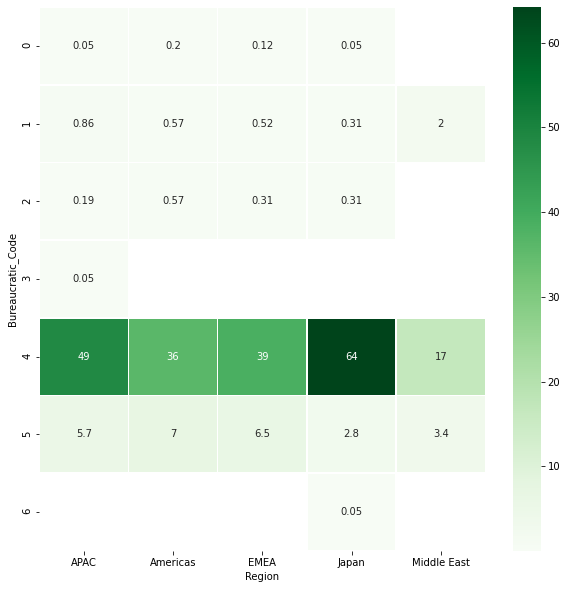

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pvt_won, annot=True, linewidths=.5, ax=ax, cmap='Greens')

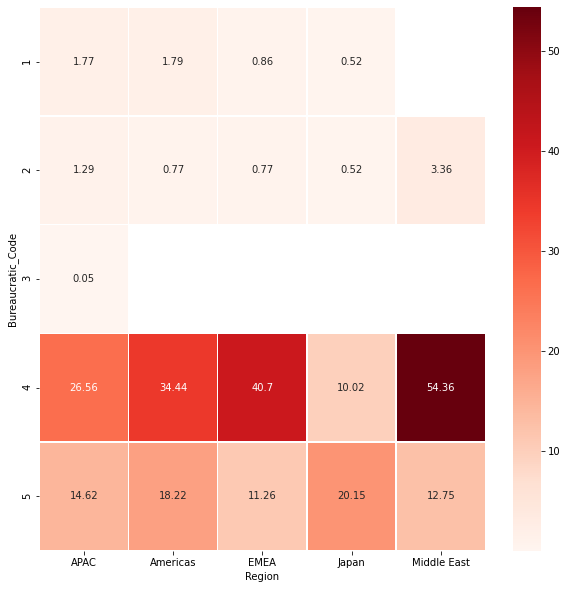

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pvt_lost, annot=True, linewidths=.5, ax=ax, cmap='Reds', fmt='g')